In [6]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
import timm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils

In [2]:
from scipy import ndimage

In [30]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jcharyton (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Paths definition

In [3]:
train_data_directory = r'../../train_data'
test_data_directory = r'../../test_data'
saved_models_directory = r'../../saved_models'
submissions_directory = r'../../submissions'

### Dataset testing

In [3]:
all_files = np.array(
    sorted(
        glob(os.path.join(train_data_directory, 'train_data', "*.npz")),
        key=lambda x: int(os.path.basename(x).replace(".npz", "")),
    )
)

In [4]:
all_files

array(['train_data/train_data/0.npz', 'train_data/train_data/1.npz',
       'train_data/train_data/2.npz', ...,
       'train_data/train_data/1729.npz', 'train_data/train_data/1730.npz',
       'train_data/train_data/1731.npz'], dtype='<U30')

In [15]:
arr = np.ma.MaskedArray(**np.load(all_files[2]))
arr.shape

(150, 11, 11)

In [16]:
arr.mask[0].shape

(11, 11)

In [17]:
arr.mask[0]

array([[ True,  True,  True,  True, False, False, False, False,  True,
         True,  True],
       [ True,  True,  True, False, False, False, False, False, False,
         True,  True],
       [ True,  True, False, False, False, False, False, False, False,
        False,  True],
       [ True, False, False, False, False, False, False, False, False,
        False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False],
       [ True,  True, False, False, False, False, False, False, False,
        False,  True],
       [ True,  True, False, False, False, False, False, False, False,
        False,  True],
       [ True,  True,  True,  True, False, False, False, False,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  Tr

In [23]:
xcenter, ycenter = ndimage.center_of_mass(arr.mask[0])
xcenter = round(xcenter)
ycenter = round(ycenter)
xcenter, ycenter

(6, 4)

In [26]:
arr.mask[0].shape

(11, 11)

In [38]:
arr.mask[0][xcenter-3:xcenter+3, ycenter-3:ycenter+3].shape

(6, 6)

In [80]:
arr.shape[1], arr.shape[2]

(93, 115)

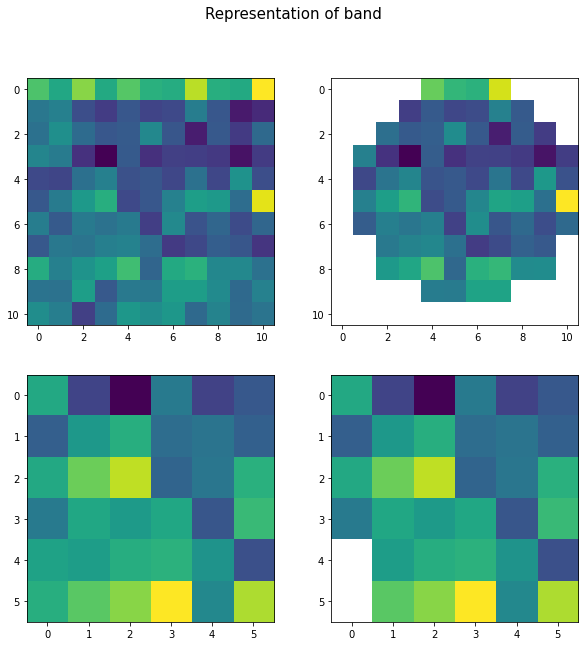

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
band_id = 145

axs[0,0].imshow(arr[band_id,:,:].data)
axs[0,1].imshow(arr[band_id,:,:])

axs[1,0].imshow(arr[band_id,xcenter-3:xcenter+3,ycenter-3:ycenter+3].data)
axs[1,1].imshow(arr[band_id,xcenter-3:xcenter+3,ycenter-3:ycenter+3])
plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [39]:
tensor_data = torch.as_tensor(arr)
tensor_data

tensor([[[ 415,  417,  426,  ...,  449,  437,  469],
         [ 400,  404,  412,  ...,  431,  422,  417],
         [ 413,  423,  403,  ...,  419,  421,  444],
         ...,
         [ 427,  434,  422,  ...,  429,  428,  446],
         [ 414,  430,  441,  ...,  467,  440,  440],
         [ 430,  417,  427,  ...,  438,  444,  420]],

        [[ 405,  416,  427,  ...,  448,  437,  471],
         [ 411,  412,  409,  ...,  425,  422,  424],
         [ 412,  422,  394,  ...,  417,  410,  440],
         ...,
         [ 423,  428,  417,  ...,  423,  423,  440],
         [ 418,  431,  432,  ...,  453,  435,  437],
         [ 427,  415,  419,  ...,  433,  434,  426]],

        [[ 402,  421,  416,  ...,  448,  439,  467],
         [ 408,  399,  401,  ...,  422,  418,  421],
         [ 406,  409,  389,  ...,  413,  408,  424],
         ...,
         [ 414,  420,  413,  ...,  415,  424,  433],
         [ 409,  423,  427,  ...,  441,  428,  428],
         [ 420,  418,  409,  ...,  433,  427,  428]],

In [42]:
tensor_data.shape

torch.Size([150, 11, 11])

In [90]:
tensor_mask_bool = ~torch.as_tensor(arr.mask)
tensor_mask_bool

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True, False, False],
         [False, False,  True,  ...,  True,  True, False],
         ...,
         [False, False,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True, False, False],
         [False, False,  True,  ...,  True,  True, False],
         ...,
         [False, False,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True, False, False],
         [False, False,  True,  ...,  True,  True, False],
         ...,
         [False, False,  True,  ...,  True,  True, False],
         [

In [75]:
tensor_mask_bool_array = tensor_mask_bool.cpu().numpy()

In [76]:
tensor_mask_bool.shape

torch.Size([150, 11, 11])

In [77]:
tensor_data_masked = torch.mul(tensor_data, tensor_mask_bool)
tensor_data_masked

tensor([[[   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,  431,    0,    0],
         [   0,    0,  403,  ...,  419,  421,    0],
         ...,
         [   0,    0,  422,  ...,  429,  428,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

        [[   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,  425,    0,    0],
         [   0,    0,  394,  ...,  417,  410,    0],
         ...,
         [   0,    0,  417,  ...,  423,  423,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

        [[   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,  422,    0,    0],
         [   0,    0,  389,  ...,  413,  408,    0],
         ...,
         [   0,    0,  413,  ...,  415,  424,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

In [78]:
tensor_data_masked_array = tensor_data_masked.cpu().numpy()

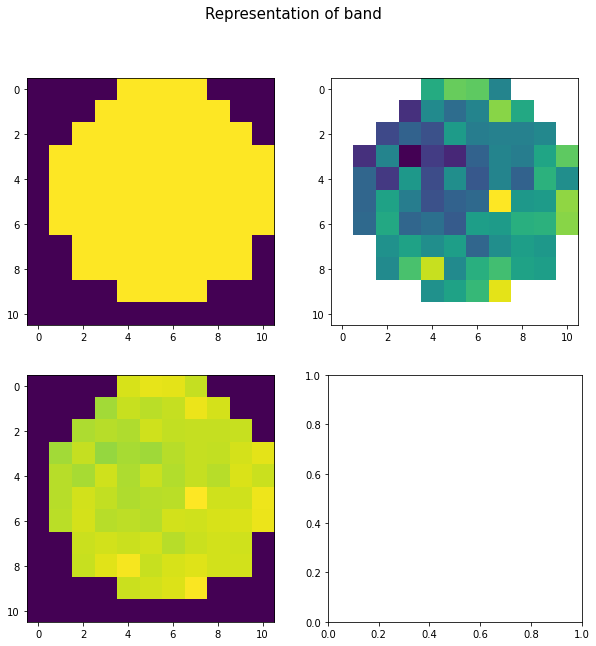

In [79]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].imshow(tensor_mask_bool_array[0,:,:].data)
axs[0,1].imshow(arr[0,:,:])

axs[1,0].imshow(tensor_data_masked_array[0,:,:])
plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [46]:
tensor_data_masked.shape

torch.Size([150, 11, 11])

In [47]:
def pad_to_minimum_size(min_size, image):
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2
        print(h_diff, w_diff)
        
        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)
        
        print(h_pad1, h_pad2, w_pad1, w_pad2)
        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)
    

In [48]:
pad_to_minimum_size(300, tensor_data_masked).shape

144.5 144.5
144 145 144 145


torch.Size([150, 300, 300])

In [80]:
tensor_mask_bool[0]

tensor([[False, False, False, False,  True,  True,  True,  True, False, False,
         False],
        [False, False, False,  True,  True,  True,  True,  True,  True, False,
         False],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [False, False, False, False,  True,  True,  True,  True, False, False,
         False],
        [False, False, False, False, Fal

In [81]:
padded_mask = pad_to_minimum_size(300, tensor_mask_bool)
padded_mask.shape

144.5 144.5
144 145 144 145


torch.Size([150, 300, 300])

In [82]:
xcenter, ycenter = ndimage.center_of_mass(padded_mask.cpu().numpy()[0])
xcenter = round(xcenter)
ycenter = round(ycenter)
xcenter, ycenter

(149, 150)

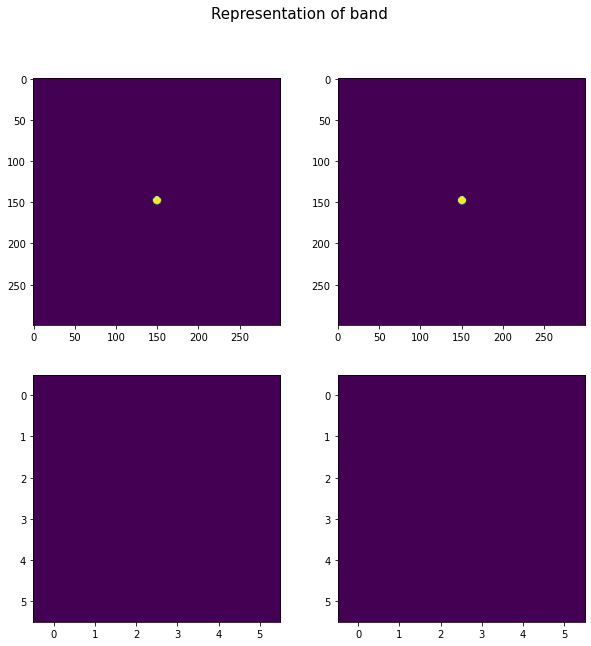

In [83]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].imshow(padded_mask.cpu().numpy()[0,:,:].data)
axs[0,1].imshow(padded_mask.cpu().numpy()[0,:,:])

axs[1,0].imshow(padded_mask.cpu().numpy()[0,xcenter-3:xcenter+3,ycenter-3:ycenter+3].data)
axs[1,1].imshow(padded_mask.cpu().numpy()[0,xcenter-3:xcenter+3,ycenter-3:ycenter+3])
plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [84]:
padded_mask.cpu().numpy()[0,xcenter-3:xcenter+3,ycenter-3:ycenter+3]

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

### Load mean and std values of training dataset

In [4]:
means_stds_arrays = np.load(os.path.join(train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

In [ ]:
tensor_data_masked_normalized = transforms.functional.normalize(torch.as_tensor(tensor_data_masked, dtype=torch.float), mean=means.tolist(), std=stds.tolist())
tensor_data_masked_normalized

In [87]:
temp_gt = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[['P','K','Mg','pH']]

In [88]:
temp_gt

,P,K,Mg,pH
0,45.1,188.0,179.0,7.2
1,44.8,205.0,188.0,7.0
2,44.4,207.0,145.0,6.8
3,46.5,204.0,143.0,6.8
4,52.0,212.0,167.0,6.7
...,...,...,...,...
1727,40.8,133.0,132.0,6.2
1728,42.7,192.0,126.0,6.5
1729,39.4,180.0,122.0,6.5
1730,37.3,162.0,127.0,6.5


In [89]:
temp_gt.loc[1, 'P']

44.8

### Dataset definition

In [5]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=True, means=None, stds=None, train_transforms=False):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['P','K','Mg','pH']]
        else:
            self.gt = None
        self.transform = transform # whether to perform transformation of input data
        self.train_transforms = train_transforms # whether to perform transformations like on training data
        
        if self.train_transforms:
            self.training_transforms_composition = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.4), transforms.RandomVerticalFlip(p=0.4)])
        
        self.means = means # mean values for every band used to normalize data
        self.stds = stds # std values for every band used to normalize data
        
        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )
    
    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2
        
        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)
        
        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float) 
        img_tensor_mask = ~torch.as_tensor(img_arr.mask) # Inverting mask is necessary due to masking method in numpy
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)
        
        if self.transform:
            img_masked_tensor_transformed = transforms.functional.normalize(img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_transformed = self.pad_to_minimum_size(304, img_masked_tensor_transformed)
            if self.train_transforms:
                img_masked_tensor_transformed = self.training_transforms_composition(img_masked_tensor_transformed)
            img_result_tensor = img_masked_tensor_transformed
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']

            sample = {'image': img_result_tensor, 'P': P_gt, 'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt}
        else:
            sample = {'image': img_result_tensor}
        
        return sample

In [6]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(train_data_directory, 'train_data'), True, means, stds, train_transforms=True)

In [7]:
train_dataset, validation_dataset = random_split(train_data_whole, [1400, 332])

### Model Testing - Transformers

In [32]:
timm.list_models()

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_x

In [33]:
model = timm.create_model('deit_base_patch16_224', in_chans=150, num_classes=4, pretrained=False, img_size=304)

In [13]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(150, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,

### Model Definition

In [8]:
# Model Parameters
model_name_timm = 'efficientnet_b7'
in_chans=150
num_classes=4
pretrained=False
img_size=304

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
BATCH_SIZE = 4
EPOCHS = 300

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4)

### Overfitting on single batch of data

In [48]:
model = timm.create_model(model_name_timm, in_chans=in_chans, num_classes=num_classes, pretrained=pretrained)
model.to(device)

TypeError: __init__() got an unexpected keyword argument 'img_size'

In [23]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [13]:
train_data_single_batch = next(iter(train_dataloader))

In [25]:
train_data_single_batch

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

In [26]:
train_data_single_batch['image'][0].shape

torch.Size([150, 304, 304])

In [27]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 304, 304])

In [28]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float))

In [29]:
output

tensor([[ 0.0079,  0.0082, -0.0117,  0.0218],
        [ 0.0237,  0.0064, -0.0013,  0.0013],
        [-0.0134,  0.0097, -0.0041,  0.0029],
        [ 0.0116,  0.0162,  0.0012,  0.0254],
        [-0.0009,  0.0073, -0.0018,  0.0131],
        [ 0.0159,  0.0035, -0.0232,  0.0035],
        [ 0.0215,  0.0076, -0.0234, -0.0130],
        [ 0.0157,  0.0003, -0.0050,  0.0042],
        [-0.0008,  0.0150, -0.0295,  0.0117],
        [ 0.0097,  0.0071, -0.0164,  0.0138],
        [ 0.0046,  0.0015, -0.0292, -0.0112],
        [ 0.0041,  0.0210, -0.0058,  0.0296]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

In [30]:
stacked_gt = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH']))
stacked_gt

tensor([[ 93.7000,  60.5000,  64.7000,  96.9000,  29.1000,  49.6000, 130.0000,
          56.9000,  85.5000,  84.0000,  64.4000,  76.5000],
        [190.0000, 172.0000, 209.0000, 294.0000, 222.0000, 239.0000, 367.0000,
         194.0000, 258.0000, 210.0000, 185.0000, 228.0000],
        [ 61.1000, 151.0000, 223.0000, 245.0000, 129.0000, 161.0000, 196.0000,
         176.0000, 163.0000, 120.0000, 125.0000, 136.0000],
        [  6.7000,   6.7000,   6.9000,   6.7100,   6.7700,   7.0000,   7.0000,
           7.0000,   6.9000,   7.3000,   6.5000,   7.4000]],
       dtype=torch.float64)

In [31]:
stacked_gt = stacked_gt.transpose(0, 1).to(device)

In [32]:
stacked_gt

tensor([[ 93.7000, 190.0000,  61.1000,   6.7000],
        [ 60.5000, 172.0000, 151.0000,   6.7000],
        [ 64.7000, 209.0000, 223.0000,   6.9000],
        [ 96.9000, 294.0000, 245.0000,   6.7100],
        [ 29.1000, 222.0000, 129.0000,   6.7700],
        [ 49.6000, 239.0000, 161.0000,   7.0000],
        [130.0000, 367.0000, 196.0000,   7.0000],
        [ 56.9000, 194.0000, 176.0000,   7.0000],
        [ 85.5000, 258.0000, 163.0000,   6.9000],
        [ 84.0000, 210.0000, 120.0000,   7.3000],
        [ 64.4000, 185.0000, 125.0000,   6.5000],
        [ 76.5000, 228.0000, 136.0000,   7.4000]], device='cuda:0',
       dtype=torch.float64)

In [33]:
loss_func(output, stacked_gt)

tensor(22273.1546, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

In [15]:
img_data_device = train_data_single_batch['image'].to(device, dtype=torch.float)
stacked_gt_device = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH'])).transpose(0,1).to(device, 
    dtype=torch.float)

model = timm.create_model(model_name_timm, in_chans=in_chans, num_classes=num_classes, pretrained=pretrained).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

for epoch in range(301):
    model.train()
    
    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()

    # Calculate MSE for each class
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
    
    if epoch%10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}')

epoch: 0, loss: 16825.140625, MSE: [5.4008999e+03 4.1947777e+04 1.9932014e+04 1.9875916e+01]
epoch: 10, loss: 5908.72412109375, MSE: [3.6066507e+02 1.8920271e+04 4.3508911e+03 3.0692096e+00]
epoch: 20, loss: 950.7932739257812, MSE: [ 793.16284   2813.33       193.7531       2.9271717]
epoch: 30, loss: 205.15289306640625, MSE: [400.35486     88.79087    331.03134      0.43455634]
epoch: 40, loss: 183.18484497070312, MSE: [363.68988 193.91766 173.08232   2.04948]
epoch: 50, loss: 100.46102905273438, MSE: [283.07693    29.624138   88.304184    0.8388756]
epoch: 60, loss: 84.08013916015625, MSE: [238.4796     18.139061   78.86506     0.8368236]
epoch: 70, loss: 70.35066223144531, MSE: [196.62918      5.1482115   78.77097      0.85432833]
epoch: 80, loss: 64.30009460449219, MSE: [165.42218      6.476269    84.561905     0.74000895]
epoch: 90, loss: 55.115745544433594, MSE: [132.93675     6.5639915  80.5155      0.4467328]
epoch: 100, loss: 75.29347229003906, MSE: [147.64592    82.121925   7

In [16]:
img_data_device = None
model = None
stacked_gt_device = None
output = None
torch.cuda.empty_cache()

### Training

In [26]:
model_name = 'Proper_Data_efficientnet_b7_BATCHSIZE_8_AdamW_LR_0_03_ReduceLROnPlateau_Factor0_6_Threshold_0_0001'

In [29]:
model = timm.create_model(model_name_timm, in_chans=in_chans, num_classes=num_classes, pretrained=pretrained).to(device)

In [36]:
wandb.watch(model, log="None", log_freq=20)

[]

In [37]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.03)

In [38]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [20]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [21]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float), 
                torch.as_tensor(torch.stack((batch_data['P'], batch_data['K'], batch_data['Mg'], batch_data['pH'])).transpose(0,1), dtype=torch.float))

In [22]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader), start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.92E-02


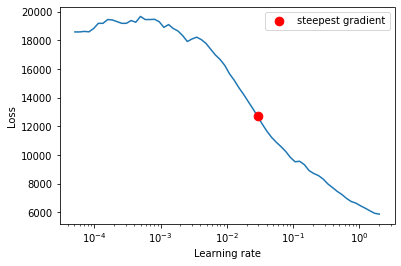

In [23]:
lr_finder.plot()
lr_finder.reset()

In [25]:
2.92E-02

0.0292

#### Continue training

In [39]:
patience_scheduler_overfit = 5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience = patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [40]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                               path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

In [41]:
config = wandb.config
config.model = 'efficientnet_b7 from timm'
config.optimizer =  'AdamW'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler =  'ReduceLROnPlateau'
config.scheduler_factor =  0.6
config.scheduler_patience =  5
config.scheduler_threshold =  0.0001
config.batch_size = BATCH_SIZE
config.notes = 'Proper data after mask fix. Using model from timm.'

In [42]:
previous_epochs = 0 # how many epochs have been done previously if resuming

In [43]:
for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []
    
    bar = tqdm(train_dataloader, position=0, leave=False, desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar: # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
        stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(0,1).to(device, dtype=torch.float)
        
        output = model(img_data_device)
        
        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)
        
        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()
        
        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_train_list.append(mse)
        
        if i % 10 == 0: # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss 
            train_log_dict['train_batch_MSE_P'] = mse[0]
            train_log_dict['train_batch_MSE_K'] = mse[1]
            train_log_dict['train_batch_MSE_Mg'] = mse[2]
            train_log_dict['train_batch_MSE_pH'] = mse[3]
            wandb.log(train_log_dict)
    
    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(np.array(mse_train_list)).mean(axis=0).numpy().tolist()
    
    print(f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}')
    wandb.log({'epoch': epoch, 'average_train_loss':avg_train_loss, 'average_train_MSE_P': avg_train_mse[0], 'average_train_MSE_K': avg_train_mse[1],
              'average_train_MSE_Mg': avg_train_mse[2], 'average_train_MSE_pH': avg_train_mse[3]})
    
    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0, leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
            stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(0,1).to(device, dtype=torch.float)
            
            output = model(img_data_device)
            
            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)
            
            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(np.array(mse_val_list)).mean(axis=0).numpy().tolist()
        
        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}')
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_val_MSE_P': avg_val_mse[0], 'average_val_MSE_K': avg_val_mse[1], 
                   'average_val_MSE_Mh': avg_val_mse[2], 'average_val_MSE_pH': avg_val_mse[3]})
        
        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break


epoch 0 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 0, LR: 0.03, train loss: 2120.137939453125, train MSE: [1147.826416015625, 5158.1748046875, 2126.193115234375, 48.3571891784668]


epoch 0 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 0, validation loss: 1882.024169921875, validation MSE: [1183.584228515625, 4313.95703125, 1990.1070556640625, 40.44890213012695]
Validation loss decreased (inf --> 1882.024170).  Saving model ...


epoch 1 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 1, LR: 0.03, train loss: 1642.353515625, train MSE: [941.6927490234375, 3931.926025390625, 1692.357666015625, 3.438023567199707]


epoch 1 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 1, validation loss: 2754.703369140625, validation MSE: [2061.54248046875, 7103.31005859375, 1821.0499267578125, 32.91122055053711]
EarlyStopping counter: 1 out of 13


epoch 2 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 2, LR: 0.03, train loss: 1637.844970703125, train MSE: [944.4111328125, 3940.905029296875, 1665.0660400390625, 0.9978441596031189]


epoch 2 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 2, validation loss: 1849.49267578125, validation MSE: [1422.046142578125, 4151.08837890625, 1824.699462890625, 0.136356383562088]
Validation loss decreased (1882.024170 --> 1849.492676).  Saving model ...


epoch 3 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 3, LR: 0.03, train loss: 1635.4417724609375, train MSE: [941.6002807617188, 3930.53173828125, 1669.2572021484375, 0.3778657019138336]


epoch 3 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 3, validation loss: 1830.3516845703125, validation MSE: [1275.5916748046875, 4171.81494140625, 1873.92041015625, 0.0796932801604271]
Validation loss decreased (1849.492676 --> 1830.351685).  Saving model ...


epoch 4 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 4, LR: 0.03, train loss: 1631.65673828125, train MSE: [940.83984375, 3931.53564453125, 1654.0374755859375, 0.21486005187034607]


epoch 4 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 4, validation loss: 1821.5333251953125, validation MSE: [1285.64111328125, 4167.384765625, 1832.906005859375, 0.2017652988433838]
Validation loss decreased (1830.351685 --> 1821.533325).  Saving model ...


epoch 5 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 5, LR: 0.03, train loss: 1633.3905029296875, train MSE: [939.739013671875, 3927.99560546875, 1665.5853271484375, 0.24221962690353394]


epoch 5 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 5, validation loss: 1827.23828125, validation MSE: [1163.12744140625, 4197.64501953125, 1948.0350341796875, 0.14570316672325134]
EarlyStopping counter: 1 out of 13


epoch 6 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 6, LR: 0.03, train loss: 1623.0166015625, train MSE: [936.5626831054688, 3903.306396484375, 1651.9884033203125, 0.2088169902563095]


epoch 6 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 6, validation loss: 1802.0167236328125, validation MSE: [1147.0472412109375, 4171.9755859375, 1888.9595947265625, 0.08424920588731766]
Validation loss decreased (1821.533325 --> 1802.016724).  Saving model ...


epoch 7 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 7, LR: 0.03, train loss: 1623.7391357421875, train MSE: [933.1926879882812, 3912.660400390625, 1648.9217529296875, 0.18139836192131042]


epoch 7 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 7, validation loss: 1867.5093994140625, validation MSE: [1062.737060546875, 4360.8955078125, 2046.2034912109375, 0.20156213641166687]
EarlyStopping counter: 1 out of 13


epoch 8 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 8, LR: 0.03, train loss: 1626.66748046875, train MSE: [930.4747314453125, 3923.133544921875, 1652.8970947265625, 0.16488537192344666]


epoch 8 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 8, validation loss: 1787.9139404296875, validation MSE: [1124.6419677734375, 4178.6015625, 1848.19677734375, 0.2159382849931717]
Validation loss decreased (1802.016724 --> 1787.913940).  Saving model ...


epoch 9 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 9, LR: 0.03, train loss: 1621.32568359375, train MSE: [921.6008911132812, 3916.832763671875, 1646.6986083984375, 0.17060290277004242]


epoch 9 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 9, validation loss: 1805.4122314453125, validation MSE: [1121.87060546875, 4199.42626953125, 1900.2677001953125, 0.08517728745937347]
EarlyStopping counter: 1 out of 13


epoch 10 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 10, LR: 0.03, train loss: 1617.0220947265625, train MSE: [920.2034912109375, 3908.260986328125, 1639.4945068359375, 0.13035394251346588]


epoch 10 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 10, validation loss: 1814.9412841796875, validation MSE: [1124.0040283203125, 4214.6318359375, 1921.060791015625, 0.06868422031402588]
EarlyStopping counter: 2 out of 13


epoch 11 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 11, LR: 0.03, train loss: 1614.3651123046875, train MSE: [913.9668579101562, 3904.05859375, 1639.300537109375, 0.13443131744861603]


epoch 11 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 11, validation loss: 1814.0472412109375, validation MSE: [1116.35888671875, 4219.10791015625, 1920.65478515625, 0.06760299205780029]
EarlyStopping counter: 3 out of 13


epoch 12 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 12, LR: 0.03, train loss: 1613.0914306640625, train MSE: [913.51953125, 3901.003173828125, 1637.6929931640625, 0.14954353868961334]


epoch 12 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 12, validation loss: 1812.630615234375, validation MSE: [1093.04443359375, 4259.69287109375, 1897.71630859375, 0.06987766176462173]
EarlyStopping counter: 4 out of 13


epoch 13 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 13, LR: 0.03, train loss: 1608.3870849609375, train MSE: [901.0781860351562, 3896.4521484375, 1635.8546142578125, 0.1631474643945694]


epoch 13 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 13, validation loss: 1821.6676025390625, validation MSE: [1164.455810546875, 4180.2998046875, 1941.833251953125, 0.08205617964267731]
EarlyStopping counter: 5 out of 13


epoch 14 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 14, LR: 0.03, train loss: 1607.0999755859375, train MSE: [897.398681640625, 3893.909912109375, 1636.940673828125, 0.1510448306798935]


epoch 14 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 14, validation loss: 1832.5506591796875, validation MSE: [1154.8536376953125, 4267.58203125, 1907.69873046875, 0.0685405358672142]
EarlyStopping counter: 6 out of 13


epoch 15 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 15, LR: 0.018, train loss: 1589.2225341796875, train MSE: [885.4183959960938, 3867.056884765625, 1604.3055419921875, 0.10867564380168915]


epoch 15 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 15, validation loss: 1751.0460205078125, validation MSE: [1008.9473266601562, 4164.19970703125, 1830.9554443359375, 0.08193966746330261]
Validation loss decreased (1787.913940 --> 1751.046021).  Saving model ...


epoch 16 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 16, LR: 0.018, train loss: 1591.9744873046875, train MSE: [881.0004272460938, 3874.4306640625, 1612.36181640625, 0.10480330139398575]


epoch 16 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 16, validation loss: 1754.04296875, validation MSE: [1007.7255859375, 4180.6064453125, 1827.769287109375, 0.07143162190914154]
EarlyStopping counter: 1 out of 13


epoch 17 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 17, LR: 0.018, train loss: 1591.1185302734375, train MSE: [880.5819702148438, 3873.765625, 1610.026123046875, 0.1000140830874443]


epoch 17 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 17, validation loss: 1768.2066650390625, validation MSE: [1009.47705078125, 4200.4521484375, 1862.8311767578125, 0.06723973155021667]
EarlyStopping counter: 2 out of 13


epoch 18 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 18, LR: 0.018, train loss: 1591.6463623046875, train MSE: [881.1213989257812, 3876.381103515625, 1608.9791259765625, 0.10372547805309296]


epoch 18 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 18, validation loss: 1746.87060546875, validation MSE: [1003.745361328125, 4168.708984375, 1814.9552001953125, 0.07307112962007523]
Validation loss decreased (1751.046021 --> 1746.870605).  Saving model ...


epoch 19 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 19, LR: 0.018, train loss: 1590.7342529296875, train MSE: [880.4785766601562, 3874.478515625, 1607.869873046875, 0.11034035682678223]


epoch 19 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 19, validation loss: 1773.7335205078125, validation MSE: [1008.8043823242188, 4205.39111328125, 1880.6705322265625, 0.06887279450893402]
EarlyStopping counter: 1 out of 13


epoch 20 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 20, LR: 0.018, train loss: 1590.135009765625, train MSE: [878.9094848632812, 3874.662109375, 1606.846435546875, 0.1224140077829361]


epoch 20 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 20, validation loss: 1756.859130859375, validation MSE: [1003.8564453125, 4176.85302734375, 1846.6600341796875, 0.06791810691356659]
EarlyStopping counter: 2 out of 13


epoch 21 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 21, LR: 0.018, train loss: 1589.3892822265625, train MSE: [879.3458862304688, 3873.407958984375, 1604.6763916015625, 0.12745258212089539]


epoch 21 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 21, validation loss: 1749.185546875, validation MSE: [1003.2684936523438, 4172.2607421875, 1821.145751953125, 0.06782285124063492]
EarlyStopping counter: 3 out of 13


epoch 22 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 22, LR: 0.018, train loss: 1589.3060302734375, train MSE: [878.2781372070312, 3874.240478515625, 1604.5814208984375, 0.12355819344520569]


epoch 22 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 22, validation loss: 1758.618896484375, validation MSE: [1003.9721069335938, 4178.93505859375, 1851.4993896484375, 0.06917492300271988]
EarlyStopping counter: 4 out of 13


epoch 23 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 23, LR: 0.018, train loss: 1588.7862548828125, train MSE: [877.9081420898438, 3872.741455078125, 1604.376953125, 0.1185791864991188]


epoch 23 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 23, validation loss: 1762.340087890625, validation MSE: [1004.8671875, 4185.478515625, 1858.945556640625, 0.06901955604553223]
EarlyStopping counter: 5 out of 13


epoch 24 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 24, LR: 0.018, train loss: 1588.3245849609375, train MSE: [877.4559936523438, 3871.654541015625, 1604.070556640625, 0.11650823056697845]


epoch 24 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 24, validation loss: 1757.8839111328125, validation MSE: [1003.84033203125, 4179.79443359375, 1847.83251953125, 0.06915432959794998]
EarlyStopping counter: 6 out of 13


epoch 25 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 25, LR: 0.010799999999999999, train loss: 1561.6094970703125, train MSE: [856.148681640625, 3803.337890625, 1586.8538818359375, 0.09663942456245422]


epoch 25 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 25, validation loss: 1740.95263671875, validation MSE: [1010.0224609375, 4173.275390625, 1780.441162109375, 0.07123343646526337]
Validation loss decreased (1746.870605 --> 1740.952637).  Saving model ...


epoch 26 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 26, LR: 0.010799999999999999, train loss: 1560.517822265625, train MSE: [853.02783203125, 3799.801513671875, 1589.1397705078125, 0.10234925150871277]


epoch 26 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 26, validation loss: 1752.16552734375, validation MSE: [1004.3075561523438, 4185.4296875, 1818.85595703125, 0.06888813525438309]
EarlyStopping counter: 1 out of 13


epoch 27 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 27, LR: 0.010799999999999999, train loss: 1561.1693115234375, train MSE: [852.6406860351562, 3802.73681640625, 1589.2052001953125, 0.09450718760490417]


epoch 27 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 27, validation loss: 1741.2861328125, validation MSE: [1009.30078125, 4172.740234375, 1783.03662109375, 0.06764905154705048]
EarlyStopping counter: 2 out of 13


epoch 28 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 28, LR: 0.010799999999999999, train loss: 1561.15673828125, train MSE: [850.5051879882812, 3787.89111328125, 1606.1180419921875, 0.11322732269763947]


epoch 28 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 28, validation loss: 1761.5003662109375, validation MSE: [1010.405517578125, 4187.78369140625, 1847.6221923828125, 0.18984700739383698]
EarlyStopping counter: 3 out of 13


epoch 29 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 29, LR: 0.010799999999999999, train loss: 1566.957275390625, train MSE: [856.0653686523438, 3819.726806640625, 1591.928955078125, 0.10811462253332138]


epoch 29 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 29, validation loss: 1741.1790771484375, validation MSE: [1013.499267578125, 4172.7333984375, 1778.4119873046875, 0.07250937819480896]
EarlyStopping counter: 4 out of 13


epoch 30 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 30, LR: 0.010799999999999999, train loss: 1562.49609375, train MSE: [853.6490478515625, 3804.541748046875, 1591.69091796875, 0.10252592712640762]


epoch 30 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 30, validation loss: 1738.13623046875, validation MSE: [1008.9937133789062, 4164.13623046875, 1779.3465576171875, 0.06812255084514618]
Validation loss decreased (1740.952637 --> 1738.136230).  Saving model ...


epoch 31 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 31, LR: 0.010799999999999999, train loss: 1561.9818115234375, train MSE: [853.5005493164062, 3803.610595703125, 1590.7091064453125, 0.10719110816717148]


epoch 31 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 31, validation loss: 1742.510009765625, validation MSE: [1011.985595703125, 4191.60693359375, 1766.38134765625, 0.06702234596014023]
EarlyStopping counter: 1 out of 13


epoch 32 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 32, LR: 0.010799999999999999, train loss: 1562.6220703125, train MSE: [853.4168090820312, 3808.298583984375, 1588.6610107421875, 0.11279447376728058]


epoch 32 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 32, validation loss: 1737.5313720703125, validation MSE: [1005.010498046875, 4176.42578125, 1768.6212158203125, 0.06879030913114548]
Validation loss decreased (1738.136230 --> 1737.531372).  Saving model ...


epoch 33 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 33, LR: 0.010799999999999999, train loss: 1562.3145751953125, train MSE: [855.2667846679688, 3806.419189453125, 1587.457275390625, 0.11462990939617157]


epoch 33 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 33, validation loss: 1738.6778564453125, validation MSE: [1004.4135131835938, 4182.65771484375, 1767.57177734375, 0.06885639578104019]
EarlyStopping counter: 1 out of 13


epoch 34 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 34, LR: 0.010799999999999999, train loss: 1563.599853515625, train MSE: [856.0280151367188, 3809.185302734375, 1589.0689697265625, 0.11703681200742722]


epoch 34 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 34, validation loss: 1737.697509765625, validation MSE: [1004.6983642578125, 4175.17138671875, 1770.8509521484375, 0.07036032527685165]
EarlyStopping counter: 2 out of 13


epoch 35 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 35, LR: 0.010799999999999999, train loss: 1563.5767822265625, train MSE: [856.480712890625, 3808.346435546875, 1589.361572265625, 0.11885631829500198]


epoch 35 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 35, validation loss: 1737.3709716796875, validation MSE: [1005.3424072265625, 4172.99365234375, 1771.0770263671875, 0.07027773559093475]
Validation loss decreased (1737.531372 --> 1737.370972).  Saving model ...


epoch 36 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 36, LR: 0.010799999999999999, train loss: 1563.6427001953125, train MSE: [855.1589965820312, 3809.211669921875, 1590.079833984375, 0.11971557885408401]


epoch 36 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 36, validation loss: 1737.0194091796875, validation MSE: [1004.33984375, 4174.7470703125, 1768.9228515625, 0.06884017586708069]
Validation loss decreased (1737.370972 --> 1737.019409).  Saving model ...


epoch 37 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 37, LR: 0.010799999999999999, train loss: 1563.19189453125, train MSE: [855.5452880859375, 3807.503173828125, 1589.6002197265625, 0.1187690943479538]


epoch 37 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 37, validation loss: 1736.981689453125, validation MSE: [1003.7948608398438, 4175.15380859375, 1768.9083251953125, 0.06996529549360275]
Validation loss decreased (1737.019409 --> 1736.981689).  Saving model ...


epoch 38 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 38, LR: 0.010799999999999999, train loss: 1563.3013916015625, train MSE: [855.7182006835938, 3807.607421875, 1589.7611083984375, 0.11877267062664032]


epoch 38 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 38, validation loss: 1740.1934814453125, validation MSE: [1005.088623046875, 4188.51025390625, 1767.104248046875, 0.07123925536870956]
EarlyStopping counter: 1 out of 13


epoch 39 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 39, LR: 0.010799999999999999, train loss: 1563.4429931640625, train MSE: [856.0021362304688, 3809.753173828125, 1587.896484375, 0.12046331912279129]


epoch 39 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 39, validation loss: 1732.469970703125, validation MSE: [1002.400146484375, 4153.79296875, 1773.61962890625, 0.06753239035606384]
Validation loss decreased (1736.981689 --> 1732.469971).  Saving model ...


epoch 40 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 40, LR: 0.010799999999999999, train loss: 1564.2041015625, train MSE: [855.3455200195312, 3810.048095703125, 1591.29833984375, 0.12444637715816498]


epoch 40 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 40, validation loss: 1736.0238037109375, validation MSE: [1003.2553100585938, 4172.5830078125, 1768.189453125, 0.06787212938070297]
EarlyStopping counter: 1 out of 13


epoch 41 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 41, LR: 0.010799999999999999, train loss: 1563.2803955078125, train MSE: [855.5416870117188, 3808.31396484375, 1589.1431884765625, 0.12240602821111679]


epoch 41 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 41, validation loss: 1737.239501953125, validation MSE: [1003.9546508789062, 4173.453125, 1771.472900390625, 0.07723680138587952]
EarlyStopping counter: 2 out of 13


epoch 42 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 42, LR: 0.010799999999999999, train loss: 1562.410400390625, train MSE: [856.6737670898438, 3803.03466796875, 1589.802001953125, 0.13097915053367615]


epoch 42 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 42, validation loss: 1737.2535400390625, validation MSE: [1003.410888671875, 4172.2275390625, 1773.3077392578125, 0.06807322055101395]
EarlyStopping counter: 3 out of 13


epoch 43 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 43, LR: 0.010799999999999999, train loss: 1562.2750244140625, train MSE: [855.375, 3801.676513671875, 1591.920654296875, 0.12798863649368286]


epoch 43 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 43, validation loss: 1735.0357666015625, validation MSE: [1002.3175659179688, 4160.85498046875, 1776.90087890625, 0.0694744735956192]
EarlyStopping counter: 4 out of 13


epoch 44 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 44, LR: 0.010799999999999999, train loss: 1561.935546875, train MSE: [856.6920776367188, 3798.8193359375, 1592.104248046875, 0.1264786720275879]


epoch 44 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 44, validation loss: 1730.106689453125, validation MSE: [1001.7056884765625, 4144.619140625, 1774.032958984375, 0.06848050653934479]
Validation loss decreased (1732.469971 --> 1730.106689).  Saving model ...


epoch 45 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 45, LR: 0.010799999999999999, train loss: 1562.5621337890625, train MSE: [858.2369384765625, 3804.65576171875, 1587.2275390625, 0.12830667197704315]


epoch 45 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 45, validation loss: 1736.5948486328125, validation MSE: [1003.5303955078125, 4169.16748046875, 1773.6090087890625, 0.07236572355031967]
EarlyStopping counter: 1 out of 13


epoch 46 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 46, LR: 0.010799999999999999, train loss: 1561.4556884765625, train MSE: [856.2642822265625, 3800.513671875, 1588.9210205078125, 0.12390118092298508]


epoch 46 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 46, validation loss: 1724.071533203125, validation MSE: [999.2692260742188, 4090.00390625, 1806.9412841796875, 0.07142985612154007]
Validation loss decreased (1730.106689 --> 1724.071533).  Saving model ...


epoch 47 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 47, LR: 0.010799999999999999, train loss: 1564.2418212890625, train MSE: [856.0814208984375, 3811.078125, 1589.6910400390625, 0.11713870614767075]


epoch 47 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 47, validation loss: 1736.313720703125, validation MSE: [1003.6348266601562, 4173.2646484375, 1768.28662109375, 0.06926622986793518]
EarlyStopping counter: 1 out of 13


epoch 48 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 48, LR: 0.010799999999999999, train loss: 1562.1319580078125, train MSE: [855.8690795898438, 3806.75634765625, 1585.7821044921875, 0.12061888724565506]


epoch 48 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 48, validation loss: 1735.62060546875, validation MSE: [1003.8707885742188, 4173.625, 1764.9185791015625, 0.06768075376749039]
EarlyStopping counter: 2 out of 13


epoch 49 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 49, LR: 0.010799999999999999, train loss: 1561.9271240234375, train MSE: [856.141357421875, 3799.49072265625, 1591.9456787109375, 0.13094931840896606]


epoch 49 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 49, validation loss: 1735.4183349609375, validation MSE: [1002.61669921875, 4170.69140625, 1768.2979736328125, 0.06793497502803802]
EarlyStopping counter: 3 out of 13


epoch 50 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 50, LR: 0.010799999999999999, train loss: 1562.64111328125, train MSE: [855.9739990234375, 3803.758544921875, 1590.6890869140625, 0.14268706738948822]


epoch 50 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 50, validation loss: 1735.685546875, validation MSE: [1003.0336303710938, 4178.92236328125, 1760.7176513671875, 0.06904276460409164]
EarlyStopping counter: 4 out of 13


epoch 51 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 51, LR: 0.010799999999999999, train loss: 1561.7650146484375, train MSE: [855.338134765625, 3803.90576171875, 1587.6728515625, 0.14327432215213776]


epoch 51 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 51, validation loss: 1736.1162109375, validation MSE: [1002.7185668945312, 4166.6044921875, 1775.0733642578125, 0.06830490380525589]
EarlyStopping counter: 5 out of 13


epoch 52 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 52, LR: 0.010799999999999999, train loss: 1561.9901123046875, train MSE: [855.7787475585938, 3804.94580078125, 1587.1041259765625, 0.13197308778762817]


epoch 52 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 52, validation loss: 1732.0408935546875, validation MSE: [1002.6839599609375, 4161.56396484375, 1763.8416748046875, 0.07447275519371033]
EarlyStopping counter: 6 out of 13


epoch 53 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 53, LR: 0.006479999999999999, train loss: 1546.898681640625, train MSE: [849.21240234375, 3766.60498046875, 1571.6824951171875, 0.09475653618574142]


epoch 53 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 53, validation loss: 1737.9189453125, validation MSE: [1003.009521484375, 4168.630859375, 1779.953857421875, 0.08181485533714294]
EarlyStopping counter: 7 out of 13


epoch 54 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 54, LR: 0.006479999999999999, train loss: 1549.1358642578125, train MSE: [848.3478393554688, 3777.13671875, 1570.9569091796875, 0.10186190158128738]


epoch 54 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 54, validation loss: 1737.760986328125, validation MSE: [1004.0532836914062, 4173.19580078125, 1773.691650390625, 0.1034589409828186]
EarlyStopping counter: 8 out of 13


epoch 55 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 55, LR: 0.006479999999999999, train loss: 1545.12744140625, train MSE: [846.8748168945312, 3760.98681640625, 1572.543212890625, 0.10467276722192764]


epoch 55 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 55, validation loss: 1741.165771484375, validation MSE: [1003.3349609375, 4171.6669921875, 1789.5709228515625, 0.08974111080169678]
EarlyStopping counter: 9 out of 13


epoch 56 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 56, LR: 0.006479999999999999, train loss: 1548.0089111328125, train MSE: [847.7838134765625, 3770.717041015625, 1573.4417724609375, 0.09253872185945511]


epoch 56 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 56, validation loss: 1739.491943359375, validation MSE: [1003.2650756835938, 4172.57470703125, 1782.0523681640625, 0.07609974592924118]
EarlyStopping counter: 10 out of 13


epoch 57 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 57, LR: 0.006479999999999999, train loss: 1547.8697509765625, train MSE: [847.9425048828125, 3767.70849609375, 1575.7357177734375, 0.092730812728405]


epoch 57 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 57, validation loss: 1738.7821044921875, validation MSE: [1003.3423461914062, 4172.93994140625, 1778.773681640625, 0.07315695285797119]
EarlyStopping counter: 11 out of 13


epoch 58 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 58, LR: 0.006479999999999999, train loss: 1548.0062255859375, train MSE: [847.50830078125, 3770.788818359375, 1573.63427734375, 0.09373664110898972]


epoch 58 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 58, validation loss: 1736.7646484375, validation MSE: [1002.9154052734375, 4170.61962890625, 1773.45166015625, 0.07189220190048218]
EarlyStopping counter: 12 out of 13


epoch 59 training data:   0%|          | 0/175 [00:00<?, ?it/s]

epoch: 59, LR: 0.003887999999999999, train loss: 1540.4317626953125, train MSE: [844.4124755859375, 3753.4775390625, 1563.7578125, 0.07967205345630646]


epoch 59 validation data:   0%|          | 0/41 [00:00<?, ?it/s]

epoch: 59, validation loss: 1735.6943359375, validation MSE: [1001.580322265625, 4162.26611328125, 1778.858642578125, 0.07285444438457489]
EarlyStopping counter: 13 out of 13
Early stopping


In [44]:
torch.save(model.state_dict(), os.path.join(saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [46]:
# rename checkpoint.pth
! mv ../../saved_models/checkpoint_state_dict.pth ../../saved_models/Proper_Data_checkpoint_state_dict_EfficientNet_b7_04_03_2022.pth

In [14]:
# load saved model
modelLoad = timm.create_model(model_name_timm, in_chans=in_chans, num_classes=num_classes, pretrained=pretrained)
modelLoad.load_state_dict(torch.load(os.path.join(saved_models_directory, 'Proper_Data_checkpoint_state_dict_EfficientNet_b7_04_03_2022.pth')))

<All keys matched successfully>

In [15]:
modelLoad = modelLoad.to(device)

### Predict test dataset

In [16]:
modelLoad.eval()

EfficientNet(
  (conv_stem): Conv2d(150, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()

In [17]:
test_data = HyperViewDataset(None, os.path.join(test_data_directory), True, means, stds, train_transforms=False)

In [18]:
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True, drop_last=False, num_workers=4)

In [19]:
len(test_data)

1154

In [20]:
output_list = []
bar = tqdm(test_dataloader, position=0, leave=False, desc=f'test data')
for test_data in bar: # for each test step
        img_data_device = test_data['image'].to(device, dtype=torch.float)
        
        output = modelLoad(img_data_device)
        output_cpu = output.detach().cpu().numpy()
        output_list.append(output_cpu)
        

test data:   0%|          | 0/289 [00:00<?, ?it/s]

In [21]:
submission = pd.DataFrame(data = [item for sublist in output_list for item in sublist], columns=["P", "K", "Mg", "pH"])
submission

,P,K,Mg,pH
0,67.084282,220.095886,156.388977,6.813354
1,67.294807,220.606049,156.613663,6.815680
2,67.025887,219.961502,156.337341,6.812871
3,67.026558,219.962738,156.337433,6.812864
4,67.003159,219.915146,156.325653,6.813177
...,...,...,...,...
1149,67.359100,220.768387,156.692947,6.815888
1150,67.511749,221.167709,156.899445,6.818746
1151,69.323402,226.018768,159.534058,6.847391
1152,68.617012,224.105103,158.471481,6.836415


In [22]:
submission.to_csv(os.path.join(submissions_directory, "Proper_data_submission_04_03_2022_EfficientNet_b7_Checkpoint.csv"), index_label="sample_index")